## Week 4: Eigenproblems

In [1]:
using LinearAlgebra
using TestImages
using LaTeXStrings
using Plots
import Random

### <font color='green'> Single eigenvalues</font>
### <font color='orange'>[Exercise 1]</font> Inverse and Rayleigh iteration
1. Given a $N\times N$ matrix $A$ and a complex number $\mu \notin \sigma(A)$, implement the inverse iteration to approximate the eigenvalue of $A$ which is closest to $\mu$
   and an associated eigenvector, using as stopping criterion that $$\|A\hat v - \hat\lambda\hat v\| \leq \varepsilon\|\hat v\|.$$

   The method will take as arguments the matrix $A$, the number $\mu$, the starting vector $x_0$, and as keyword arguments the tolerance $\varepsilon$ and a maximum number of iterations before aborting.
   Return a triplet $(\lambda_n,v_n,n)$ with the approximate (normalized) eigenpair and the number $n$ of iterations taken.
   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   - By functional calculus, $\lambda_j = \underset{\lambda\in \sigma(A)}{\mathrm{argmin}} |\lambda-\mu|$ if and only if $(\lambda_j-\mu)^{-1}$ is the dominant eigenvalue of $(A-\mu I_N)^{-1}$
   - It is <b>not</b> necessary (or efficient) to compute the inverse of $A-\mu I_N$ (read the documentation for `LinearAlgebra.factorize`)
   - The identity matrix need not be created explicitly;
     To construct $A - \mu I_N$, simply write `A - μ*I` (assuming that `LinearAlgebra` has been imported with `using`)
   </details>

In [2]:
function inverse_iteration(A, μ, x₀; tol=1e-12, maxiter=100)
    x = copy(x₀)
    ### BEGIN SOLUTION
    M = factorize(A-μ*I)
    niter = 0
    while niter < maxiter
        niter += 1
        x .= M\x
        norm2_x = x'x
        norm_x = √norm2_x
        x /= norm_x
        λ = x'A*x
        (norm(A*x - λ*x) ≤ tol) && return (λ,x,niter)
    end
    ### END SOLUTION
    return nothing
end

inverse_iteration (generic function with 1 method)

2. Implement the Rayleigh quotient iteration, taking as arguments the matrix $A$, the initial $\mu_0$, the initial vector $x_0$, and as keywords the tolerance $\varepsilon$ and a maximum number of iterations. As above, return a triple with the eigenpair and the number of iterations taken, using the same stopping criterion.
    <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   - This method amounts to setting $\mu_k$ to the current estimate of the target eigenvalue, which is the Rayleigh quotient $\frac{v_k^* A v_k}{v_k^*v_k}$.
   - Again, no need to invert $A-\mu_k I_N$. Should you use `LinearAlgebra.factorize`?
   </details>

In [3]:
function rayleigh_iteration(A, μ₀, x₀; tol=1e-12, maxiter=100)
    x = copy(x₀)
    μ = μ₀
    niter = 0
    ### BEGIN SOLUTION
    while niter < maxiter
        niter += 1
        x .= (A - μ*I) \ x
        norm2_x = x'x
        norm_x = √norm2_x
        x /= norm_x
        μ = x'A*x
        (norm(A*x - μ*x) ≤ tol) && return (μ,x,niter)
    end
    ### END SOLUTION
    return nothing
end

rayleigh_iteration (generic function with 1 method)

Play with the value of $N$ in the code below (keep $N$ below 1000).
There is no guarantee that the Rayleigh iteration method will converge to the eigenvalue closest to $\mu_0$, so you may have to run the cell a few times for this to happen.
 Is the Rayleigh quotient method faster in number of iterations? In wall-clock time? Why?

In [4]:
# Test code
Random.seed!(2025)
N = 1000
A = randn(N,N); A = A*A'/N
x₀ = randn(N); x₀ /= √(x₀'x₀)
μ = 2.0
ε = 1e-12

@time result = inverse_iteration(A,μ,x₀;tol=ε)
result === nothing ? println("Inverse iteration did not converge.") : begin λ,x,n = result ; println("Inverse iteration: eigenvalue $(λ) found in $n iterations.") end
@time result = rayleigh_iteration(A,μ,x₀;tol=ε)
result === nothing ? println("Rayleigh iteration did not converge.") : begin λ_r,x_r,n_r = result ; println("Rayleigh quotient iteration: eigenvalue $(λ_r) found in $n_r iterations.") end

### BEGIN HIDDEN TESTS
if abs(λ-λ_r) < 1/N^2 # A has about N eigenvalues in [0,4]
    @assert (abs(λ-λ_r) ≤ 2ε)
    @assert all(abs.((x'A*x_r)/(x'x_r) .- λ) .≤ ε)
end

@assert n_r ≤ n
### END HIDDEN TESTS

  1.182092 seconds (3.60 M allocations: 210.233 MiB, 2.18% gc time, 96.07% compilation time)
Inverse iteration: eigenvalue 1.9983782746955578 found in 27 iterations.
  0.155801 seconds (20.56 k allocations: 108.258 MiB, 17.79% gc time, 23.02% compilation time)
Rayleigh quotient iteration: eigenvalue 1.9873152321450813 found in 7 iterations.


### <font color='green'> Multiple eigenvalues</font>
From now on, $A$ will be a Hermitian matrix.
### <font color='orange'>[Exercise 2]</font> Subspace iteration and SVD
The subspace iteration method is defined, given an initial condition $X_0\in\mathbb C^{n\times p}$, by the recursion:
$$ X_{n+1} R_{n+1} = A X_n,$$
where $X_{n+1} R_{n+1}$ is the partial QR decomposition of $AX_n \in \mathbb C^{n\times p}$. One can show, under suitable conditions, that the columns of $X_n$ converge to the $p$ dominant eigenvectors of $A$ (see lecture notes).


1. Implement the partial QR decomposition, i.e. a function `myQR` taking as argument a $n\times p$ matrix $M$ and returning $Q,R$,
   where $Q$ is a $n\times p$ orthogonal matrix and $R$ is a $p\times p$ upper triangular matrix with positive diagonal entries.
    <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

    - Use induction on $p$, writing $$ Q = \begin{pmatrix} \widetilde Q &\mathbf{q}\end{pmatrix},\qquad R = \begin{pmatrix} \widetilde R & \mathbf{r} \\ 0 & \alpha\end{pmatrix}, \qquad M=\begin{pmatrix} \widetilde{M} & \mathbf m\end{pmatrix},$$ with $\widetilde Q,\widetilde M \in \mathbb C^{n\times (p-1)}$, $\widetilde R\in\mathbb C^{(p-1)\times (p-1)}$, $\mathbf r \in \mathbb C^{p-1}$, $\alpha\in \mathbb R_+$ et $\mathbf m\in \mathbb C^n$, assuming you know the decomposition $\widetilde Q \widetilde R = \widetilde M$ of the matrix consisting of the $(p-1)$ first columns of $M$ (the case $p=1$ is trivial).
   </details>

- To avoid unecessary memory allocations, it is often useful in Julia to use `view(A,ix...)` instead of `A[ix...]` when performing array operations.
  To understand why, recall from Week 1 that Julia will by default allocate memory when slicing an array as an r-value `B = A[ix...]` (`B` is a <b>copy</b> of the slice of `A`) vs slicing as a l-value.
  As a result, the following happens in Julia:
  ```julia
      A = randn(20000,20000)
      A[1:20000,1] === A[1:20000,1]
      # false
  ```
  To avoid this, the method `view(A,ix...)` returns <b>a reference</b> to the slice of `A`, which behaves in other regards as an array. For example:
  ```julia
      @time A[1:20000,1]'A[1,1:20000]
      # 0.000655 seconds (6 allocations: 312.625 KiB)
      @time view(A,1:20000,1)'view(A,1,1:20000)
      # 0.000369 seconds (4 allocations: 208 bytes)
  ```
  For convenience, Julia also provides the [macro](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros) `@views` which transforms every expression of the form `A[ix...]` into one of the form `view(A,ix...)` in the code on which it operates:
  ```julia
      @views A[1:20000,1] === A[1:20000,1] # transforms a line of code
      # true

      @time @views A[1:20000,1]'A[1,1:20000]
      # 0.000289 seconds (4 allocations: 208 bytes)

      @views function f(M) # or a full block of code
              return M[1:20000,1]'M[1,1:20000]
          end
      @time f(A)
      # 0.000314 seconds (1 allocation: 16 bytes)
  ```

In [5]:
@views function myQR(M)
    n,p = size(M)

    @assert p <= n "Error: p > n"

    Q = zero(M)
    R = zeros(eltype(M),p,p)

    ### BEGIN SOLUTION

    for k=1:p
        m = view(M, :, k)
        Q̃ = view(Q, :, 1:k-1)
        r = view(R, 1:k-1, k)
        q = view(Q, :, k)
        
        r .= Q̃'m
        q .= m - Q̃*r
        α = sqrt(q'q)
        q ./= α
        R[k,k] = α
    end

    ### END SOLUTION

    return Q,R
end

myQR (generic function with 1 method)

In [6]:
# Test code
M = randn(ComplexF64,100,50)
M = big.(M)
Q,R = myQR(M)
@show norm(Q*R-M)

### BEGIN HIDDEN TESTS
@assert norm(Q*R-M) < 1e-50
@assert norm(Q'Q-I) < 1e-50
@assert all(isreal.(diag(R)))
@assert all(real.(diag(R)) .>= 0)
### END HIDDEN TESTS

norm(Q * R - M) = 1.036416049574850419425422173720991419736827080356812444774911952379079269252268e-75


2. Implement the subspace iteration, taking as arguments the matrix $B$, the number of eigenvalues $p$, and a fixed number of iterations $n = $`niter`.
   Return the approximate eigenpairs $(\boldsymbol{\lambda}_n,X_n)$ after $n$ iterations.

In [7]:
function myEigen(B, p, niter)

    ### BEGIN SOLUTION
    n = size(B, 1)
    X = randn(n, p)
    R = zeros(p,p)
    for i in 1:niter
        X, R = myQR(B*X)
    end
    λs = diag(X'*B*X)
    ### END SOLUTION

    return λs, X
end

myEigen (generic function with 1 method)

In [8]:
@show myEigen([1. 2.; 2. 1.], 2, 100)[1]
@show myEigen([1. 2.; 2. 1.], 2, 100)[2]

### BEGIN HIDDEN TESTS
@assert begin n = 2; A = randn(n, n); myEigen(A'A, n, 100)[1] ≈ reverse(eigen(A'A).values) end
@assert begin n = 4; A = randn(n, n); myEigen(A'A, n, 100)[1] ≈ reverse(eigen(A'A).values) end
@assert begin A = randn(5, 5); q, r = qr(A); B = q*Diagonal(1:5)*q'; myEigen(B, 3, 100)[1] ≈ [5; 4; 3] end
### END HIDDEN TESTS

(myEigen([1.0 2.0; 2.0 1.0], 2, 100))[1] = [3.0, -1.0]
(myEigen([1.0 2.0; 2.0 1.0], 2, 100))[2] = [-0.7071067811865475 0.7071067811865476; -0.7071067811865475 -0.7071067811865476]


Recall the singular value decomposition for a $B \in \mathbb C^{m\times n}$
$$B = U \Sigma V^*, \quad U\in \mathbb C^{m\times m},\quad \Sigma \in \mathbb R^{m\times n},\quad V\in \mathbb C^{n\times n},$$
where $U U^* = U^* U = I_m$, $V V^* = V^* V = I_n$,
and $\Sigma \in \mathbb R^{m \times n}$ is a rectangular diagonal matrix with non-negative real entries on the diagonal.
The columns of $U$ (resp. $V$) are called the left (resp. right) singular vectors of $B$, and the diagonal entries of $\Sigma$ are the (non-negative) singular values.

3. Write a function `mySVD(B, p, niter)`
   that returns the `p` dominant singular values of **square** matrix `B` (in a vector `σs`),
   together with the associated left and right singular vectors (in matrices `Up` and `Vp`).

    <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

    - Notice that if $A$ is a square matrix
      $$
      A A^* = U \Sigma^2 U^*, \qquad
      A^* A = V \Sigma^2 V^*.
      $$
      Therefore, the left singular vectors of $A$
      are the eigenvectors of $A A^*$,
      while the right singular vectors of $A$
      are the eigenvectors of $A^* A$.

   - Once you have calculated the left and right singular vectors
     associated with the `p` dominant singular values,
     the singular values themselves can be obtained by extracting the diagonal from the matrix
     $$
     \Sigma_p = U_p^* B V_p.
     $$
     Here $U_p$ and $V_p$ are the matrices containing as columns the left and right singular vectors associated with the `p` dominant singular values,
     respectively.

   </details>

In [9]:
function mySVD(B, p, niter)

    ### BEGIN SOLUTION
    n = size(B, 1)
    λ₁, U = myEigen(B*B', p, niter)
    λ₂, V = myEigen(B'B, p, niter)
    σs = U'B*V
    ### END SOLUTION
    return diag(σs), U, V
end

mySVD (generic function with 1 method)

In [10]:
n = 10
B = randn(n, n)
σs, U, V = mySVD(B, n, 1000)
@assert norm(U'U - I(n)) < 1e-10
@assert norm(V'V - I(n)) < 1e-10
@assert norm(U*Diagonal(σs)*V' - B) < 1e-10

4. The singular value decomposition is very useful for compressing matrices.
   The idea of matrix compression based on SVD is the following:
   given $p \leqslant n$, a matrix $B \in \mathbb C^{n\times n}$
   (we consider square matrices for simplicty)
   can be approximated by
   $$
   \widetilde {B} := U_p \Sigma_p V_p^*,
   $$
   where $\Sigma_p \in \mathbb R^{p \times p}$ is a diagonal matrix containing the $p$ dominant singular values of $B$ on its diagonal,
   and where $U_p \in \mathbb C^{n \times p}$ and $V_p \in \mathbb C^{n \times p}$ are rectangular matrices containing the associated left and right singular vectors,
   respectively.

   Since a grayscale image can be represented by a matrix containing the intensity values of all the pixels,
   this approach for compressing matrices can be used for compressing grayscale images.
   Use this method, i.e. calculate $\widetilde {B}$, for $p \in \{5, 10, 20, 30\}$,
   in order to compress the image `woman_darkhair` given below (other available test images are listed [here](https://testimages.juliaimages.org/stable/imagelist/)),
   and plot the compressed image for these values of `p`.

   **Remarks**:
   - (For information only) In practice, instead of storing the full matrix $\widetilde {B}$,
     which contains $n^2$ entries,
     we can store only the matrices $U_p$, $\Sigma_p$ and $V_p$,
     which together contain only $(2n+1)p$ entries (we only count the $p$ diagonal entries of $\Sigma_p$).
     If $p \ll n$,
     then the memory required to store these matrices is much smaller than the memory required to store the initial matrix $B$.

   - A function for drawing images based on the matrix of pixel intensity values is provided below, and serves as a test for your implementation.

p = 5, compression ratio = 0.019550323486328125
p = 10, compression ratio = 0.03910064697265625
p = 20, compression ratio = 0.0782012939453125
p = 30, compression ratio = 0.11730194091796875


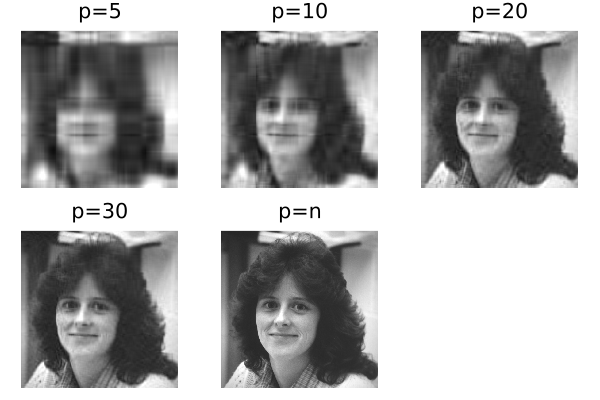

In [11]:
A = testimage("woman_darkhair")

# Convert image to matrix of Float64
M = Float64.(A)
n = size(M,1)

# Function to plot a grayscale image from the matrix
# containing the intensity values of all the pixels
function plot_matrix(B, p)
    plot(Gray.(B), ticks=false, showaxis=false, title="p=$p")
end

plots = typeof(plot())[]

for p in [5,10,20,30]
    niter = 100
    σs, U, V = mySVD(M, p, niter)
    println("p = $p, compression ratio = ", ((2n+1)*p)/(n^2))
    push!(plots,plot_matrix(U*Diagonal(σs)*V', p))
end

push!(plots, plot_matrix(M, "n"))
plot(plots...)

### <font color='green'>Using sparse matrices for high-dimensional problems</font>
### <font color='orange'>[Exercise 3]</font> PageRank algorithm

[PageRank](https://en.wikipedia.org/wiki/PageRank) is an algorithm that assigns a score to the vertices of a directed graph.
It used to be used by major search engines to rank search results. In this context, the directed graph encodes the links between pages on the World Wide Web,
with the vertices representing web pages and the edges representing connections between pages:
there is an edge from page $i$ to page $j$ if page $i$ contains a hyperlink to page $j$.

Let us consider a directed graph $G(V, E)$ with vertices $V = \{1, \dotsc, n\}$ and edges $E$. The graph can be represented by its adjacency matrix $A \in \{0, 1\}^{n \times n}$, where the entries are given by
$$
a_{ij} =
\begin{cases}
    1 & \text{if there is an edge from $i$ to $j$,} \\
    0 & \text{otherwise.}
\end{cases}
$$
The idea of the PageRank algorithm, in its simplest form, is to assign scores $r_i$ to the vertices by solving the following system of equations:
$$ \tag{PageRank}
    \forall i \in  V, \qquad
    r_i
    = \sum_{j \in \mathcal N(i)} \frac{r_j}{o_j}.
$$
<span id="pagerank"></span>
where $o_j$ is the out-degree of vertex $j$, i.e., the number of edges with origin $j$. Here, the sum applies to the set of nodes in $\mathcal N(i)$, which represents the set of incoming neighbors of vertex $i$, i.e., those that have an edge pointing to vertex $i$.

Let $\mathbf r = \begin{pmatrix} r_1 & \dots & r_n \end{pmatrix}^T$. It is straightforward to show that solving the system <a href="#pagerank">(PageRank)</a> is equivalent to solving the following problem:
$$  \tag{PageRank-vector}
    \mathbf r =
    A^T
    \begin{pmatrix}
        \frac{1}{o_1} & &  \\
                      & \ddots & \\
                      & & \frac{1}{o_n}
    \end{pmatrix}
    \mathbf r =:  A^T O^{-1} \mathbf r.
$$
<span id="pagerank"></span>
In other words, the problem boils down to finding an eigenvector with eigenvalue $1$ of the matrix $M = A^T O^{-1}$. Note that at this stage, 
we have proved neither the existence nor the uniqueness of a solution to this equation. The question of the uniqueness of a solution is related to the connectivity of the graph and will not be addressed here. However, we will demonstrate that a solution to the problem exists.

**Remark.** The matrix $O^{-1} A$ is the transition matrix of a random walk on the directed graph, where at each step a move is made to an outgoing neighbor, with equal probability for each of them. Solving <a href="#pagerank">(PageRank-vector)</a> is equivalent to finding a stationary distribution of this random walk.

1. - Note that $M$ is a left stochastic matrix, i.e., the sum of the elements in each column is equal to 1.

    - Prove that the eigenvalues of any matrix $B \in \mathbb R^{n \times n}$ coincide with those of $B^T$. You can use the fact that $\det(B) = \det(B^T)$.

    - Using the previous points, show that $1$ is an eigenvalue and that $\rho(M) = 1$. For the second part, find a subordinate matrix norm such that $\lVert M\rVert= 1$. This demonstrates the existence of a solution to <a href="#pagerank">(PageRank-vector)</a>, and also proves that $1$ is the dominant eigenvalue of $M$.

We will apply PageRank to sort Wikipedia pages according to their importance. The two following cells download and parse the data into arrays. To limit computation time, only 5% of the best scored articles have been selected.


In [12]:
import Downloads
import Tar

# URL where data can be downloaded
url = "https://urbain.vaes.uk/static/wikidata.tar"

# Download the data
filename = "wikidata.tar"
isfile(filename) || Downloads.download(url, filename)

# Extract data into directory `wikidata`
directoryname = "wikidata"
isdir(directoryname) || Tar.extract(filename, directoryname)

"wikidata"

In [13]:
import CSV
import DataFrames

# Read nodes and edges into data frames
nodes_dataframe = CSV.read("$directoryname/names.csv", DataFrames.DataFrame)
edges_dataframe = CSV.read("$directoryname/edges.csv", DataFrames.DataFrame)

# Convert data to matrices
nodes = Matrix(nodes_dataframe)
edges = Matrix(edges_dataframe)

# The data structures should be self-explanatory
edges_dataframe

Row,FromNode,ToNode
,Int64,Int64
1,175973,1
2,130880,2
3,145856,2
4,159190,2
5,159200,2
6,159207,2
7,159431,2
8,4,3
9,5,3


How many nodes are there? Compute the memory required to store every entry of $M$ using the `Float64` format.

2. Implement a structure `struct MySparseMatrix` to represent a sparse matrix with `Float64` entries (in the COO format), and a method `*(M::MySparseMatrix,X::Vector{Float64})` to compute the product of a sparse matrix `M` by a vector `X`.

In [14]:
import Base.*

struct MySparseMatrix
    rows::Vector{Int}
    cols::Vector{Int}
    vals::Vector{Float64}
    m::Int
    n::Int
end

MySparseMatrix(R::Vector{Int},C::Vector{Int},V::Vector{Float64}) = MySparseMatrix(R,C,V,maximum(R),maximum(C))

@inbounds function *(M::MySparseMatrix, X::Vector{Float64})
    @assert size(X, 1) == M.n "Incompatible dimensions: M has $(M.n) columns but X has $(length(X)) rows."
    ### BEGIN SOLUTION
    Y = zeros(M.m)
    for (i,j,v) = zip(M.rows, M.cols, M.vals)
        Y[i] += v*X[j]
    end
    return Y
    ### END SOLUTION
end

* (generic function with 318 methods)

Test your code with the cell below:

In [15]:
m, n = 4, 3
R = [2, 2, 2, 3, 3]
C = [1, 2, 3, 1, 3]
V = [5., 6., 7., 8., 9.]
A = MySparseMatrix(R, C, V, m, n)
b = [1.; 1.; 1.]
@assert A*b == [0.; 18.; 17.; 0.] "Multiplication does not work!"

3. Construct the left-stochastic matrix $M$:

In [16]:
nn, ne = length(nodes), size(edges, 1)

### BEGIN SOLUTION
# Count the number of outbound edges for each node
n_outbound = zeros(Int, nn)
for e in eachrow(edges)
    n_outbound[e[1]] += 1
end

# Build matrix
R, C = edges[:, 1], edges[:, 2]
V = 1 ./ n_outbound[R]
### END SOLUTION

M = MySparseMatrix(C, R, V)

MySparseMatrix([1, 2, 2, 2, 2, 2, 2, 3, 3, 3  …  29807, 104616, 120348, 198551, 116918, 190926, 112376, 108047, 84697, 154081], [175973, 130880, 145856, 159190, 159200, 159207, 159431, 4, 5, 6887  …  30983, 76929, 86508, 128270, 152419, 156536, 170697, 177550, 181302, 189293], [0.025, 0.007936507936507936, 0.012658227848101266, 0.0625, 0.017543859649122806, 0.02564102564102564, 0.0037174721189591076, 0.07692307692307693, 0.08333333333333333, 0.0125  …  0.1, 0.5, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 1.0, 1.0], 199903, 199903)

4. Implement the power iteration to compute the eigenvector associated with the principal eigenvalue of $M$.
   Since the eigenvalue $\lambda=1$ is known, you can use $\|Mr-r\| \leq \varepsilon\|r\|$ as a stopping criterion.

In [17]:
function power_iteration(M, x; ε=1e-12, maxiter=1000)
    ### BEGIN SOLUTION
    niter = 0
    while niter < maxiter
        niter += 1
        x = x / √(x'x)
        Mx = M*x
        λ = x'Mx
        e = norm(Mx - λ*x)
        x = Mx
        e ≤ ε && return x
    end
    return nothing
    ### END SOLUTION
    # Return only the eigenvector, not the eigenvalue
end

power_iteration (generic function with 1 method)

In [18]:
@assert [1, -1]'power_iteration([1. 2.; 2. 1.], [1., 0.]) |> abs < 1e-9
@assert [1, 0]'power_iteration([0. 0.; 0. 1.], [1., 1.]) |> abs < 1e-9
@assert [0, 1]'power_iteration([1. 0.; 0. .5], [1., 1.]) |> abs < 1e-9

The next cell runs PageRank:

In [19]:
x = ones(nn) / nn
x = @time power_iteration(M, x)

p = sortperm(x, rev=true)
sorted_nodes = view(nodes, p)

print(join(sorted_nodes[1:20], "\n"))
@assert sorted_nodes[1] == "United States"
@assert sorted_nodes[2] == "United Kingdom"
@assert sorted_nodes[3] == "World War II"
@assert sorted_nodes[4] == "Latin"
@assert sorted_nodes[5] == "France"

  5.823675 seconds (7.99 k allocations: 1.126 GiB, 6.83% gc time, 0.24% compilation time)
United States
United Kingdom
World War II
Latin
France
Germany
English language
China
Canada
India
Mathematics
Italy
Catholic Church
Australia
Greek language
Europe
England
World War I
London
Russia

5. Write a function `search(keyword)` to perform a search in the database. Here's an example of what this function could return:

   ```
   julia> search("Newton")
   47-element Vector{String}:
    "Isaac Newton"
    "Newton (unit)"
    "Newton's laws of motion"
    …
   ```
   <details>
         <summary>
         <em><font color='gray'>Hint (click to display)</font></em>
      </summary>

      - The method `filter(condition, itr)` returns a filtered version of the iterable `itr` with only the elements `x` satisfying `condition(x) == true` remaining.
      - The method `occursin(needle::String, haystack::String)` returns `true` if and only if `needle` is a substring of `haystack`.

      Of course, the best way to understand these methods is to <strong> read the documentation </strong>.
   </details>

In [20]:
function search(keyword)
    ### BEGIN SOLUTION
    filter(s -> occursin(keyword, s), sorted_nodes)
    ### END SOLUTION
end

search("Newton")

47-element Vector{String}:
 "Isaac Newton"
 "Newton (unit)"
 "Newton's laws of motion"
 "Newton's law of universal gravitation"
 "Newton's method"
 "Newtonian fluid"
 "Non-Newtonian fluid"
 "Newton metre"
 "Newton, Massachusetts"
 "Olivia Newton-John"
 ⋮
 "Robert Newton"
 "John Gilbert Newton Brown"
 "Newton's inequalities"
 "Newton's method in optimization"
 "Thandie Newton"
 "Wayne Newton"
 "Post-Newtonian expansion"
 "Quasi-Newton method"
 "Helmut Newton"